# 3D-to-2D rigid registration

The goal is to find the best rotation matrix that rotates and projects the 3D source point cloud and registers with the 2D target. We use kernel correlation and mixture of Gaussians as the metric to do this. If we consider the weighted point clouds as $\mathcal X$ and $\mathcal Y$ for the 2D target and the 3D source respectively,

1. Kernel correlation - see implementation under `bayalign.score.KernelCorrelation`
$$
K(\pmb R) := (\mathcal X \star \mathcal Y)(\pmb{R}) = \sum_{k=1}^K \sum_{l=1}^L w_k\, v_l\, \phi(\pmb y_l - \pmb{PR} \pmb x_k)
$$

This can be scaled by an inverse temperature parameter $\beta$ and can be considered as a proxy for log probability and is therefore $\log p(\pmb R) \propto \beta \cdot \log K(\pmb R)$.

2. Mixture of spherical Gaussians - see implementation under `bayalign.score.MixtureSphericalGaussians`
$$
\log p(\mathcal Y|\mathcal X) = \sum_{l=1}^L v_l \log \left( \sum_{k=1}^K w_k\, \phi \left(\pmb y_l - \pmb{PR} \pmb x_k \right)\right)
$$


In [2]:
import matplotlib.pylab as plt
import numpy as np
from scipy.spatial.transform import Rotation
from bayalign.pointcloud import RotationProjection
from examples.plotting_utils import show_3d_pointcloud

### Load the known 3D model

A precomputed 3D model (of a protein structure) based on Gaussian RBF network is loaded as a source that must be optimally rotated and projected to match a 2D target point cloud.

In [3]:
# load 3D model
n_particles = (1000, 2000)[0]
model_3d = np.load(f"examples/data/ribosome_80S/model3d_{n_particles}.npz")

# initialize it as source, an instance of ProjectionRotation
source_cloud = RotationProjection(
    model_3d["positions"], model_3d["weights"]
).centered_copy()

# show the point cloud
show_3d_pointcloud(source_cloud.positions, pc_size=5, color_by_neighbours=True)

### Convert class average to target point cloud

From the class average projection image, pixels that are the most centrally connected region are converted to a point cloud as a target with the weights being the pixel values of the class average.

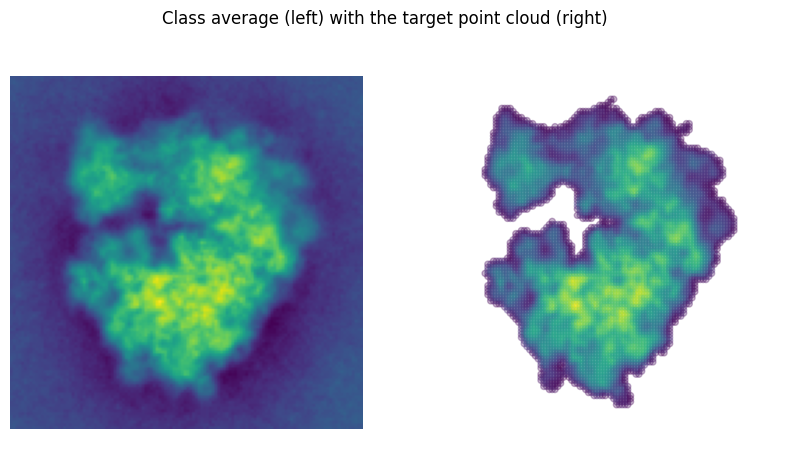

In [4]:
from examples.cryo_utils import load_class_average, pointcloud_from_class_avg

# index specifies which projection will be used as a target
class_avg_idx = 5
image = load_class_average(class_avg_idx)
target_cloud = pointcloud_from_class_avg(image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
limit = len(image) // 2 * 2.68

axes[0].imshow(image.T, extent=(-limit, limit, -limit, limit), origin="lower")
axes[1].scatter(*target_cloud.positions.T, c=target_cloud.weights, alpha=0.3, s=20)
fig.suptitle("Class average (left) with the target point cloud (right)")

for ax in axes:
    scale = 0.7
    ax.set_xlim(-scale * limit, scale * limit)
    ax.set_ylim(-scale * limit, scale * limit)
    ax.set_axis_off()

### Fit an optimal 2D model to the target

The 2D model is fit to the target using Expectation Maximization (EM). This effectively assigns most optimal positions with an estimate for $\sigma$, the width of the gaussian RBF kernel.

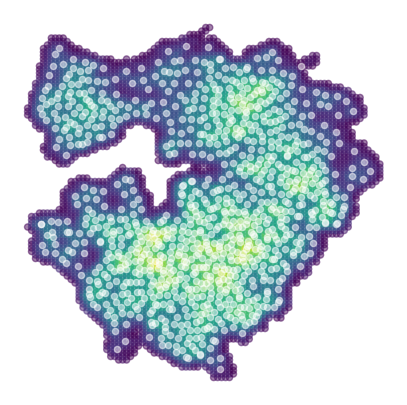

In [5]:
from examples.cryo_utils import fit_model2d

# best fit to estimate the points and a scalar sigma
target_fit2d, sigma = fit_model2d(target_cloud, n_particles, n_iter=100, k=50)

# overlaying the target and the fit
plt.figure(figsize=(5, 5))
plt.axis("off")
plt.scatter(*target_cloud.positions.T, c=target_cloud.weights, alpha=0.5, s=20)
plt.scatter(*target_fit2d.positions.T, color="w", alpha=0.5, s=20)

In [9]:
from bayalign.inference import (
    Sampler,
    RejectionSphericalSliceSampler,
    ShrinkageSphericalSliceSampler,
    MetropolisHastings,
    SphericalHMC,
)
import os
from bayalign.utils import take_time
from bayalign.score import KernelCorrelation, MixtureSphericalGaussians
from bayalign.sphere_utils import sample_sphere
import h5py
from jax import random
from typing import Sequence

METHODS = ("sss-reject", "sss-shrink", "rwmh", "hmc")
SAMPLERS = (
    RejectionSphericalSliceSampler,
    ShrinkageSphericalSliceSampler,
    MetropolisHastings,
    SphericalHMC,
)


def load_or_compute(
    filedir: str,
    n_samples: int,
    burnin: int,
    target_pdf: KernelCorrelation | MixtureSphericalGaussians,
    seed: int = 3521,
    methods: tuple[str] = METHODS,
    samplers: Sequence[Sampler] = SAMPLERS,
    load_precomputed: bool = True,
):
    # pdf is defined on 3-sphere
    key = random.key(seed)
    init_state = sample_sphere(key, d=3)

    samples = {}
    log_probs = {}

    for method, sampler in zip(methods, samplers):
        savefilename = f"{method.replace('-', '_')}.npz"
        filepath = os.path.join(filedir, savefilename)

        # check if the file exists
        if load_precomputed and os.path.isfile(filepath):
            print(f"loading samples for {method}...")
            # load the results
            loaded_samples = np.load(filepath)
            print(f"loading samples for {method}...")
            samples[method] = np.asarray(loaded_samples["samples"])
            log_probs[method] = np.asarray(loaded_samples["log_probs"])

        # run sampler if not found
        else:
            with take_time(f"Sampling for {method}"):
                sampler_instance: Sampler = sampler(target_pdf, init_state, seed)
                samples[method] = sampler_instance.sample(n_samples, burnin)

                # compute log probabilities
                log_probs[method] = np.asarray(
                    [target_pdf.log_prob(angle) for angle in samples[method]]
                )

            # save the results
            np.savez(
                filepath,
                samples=samples[method],
                log_probs=log_probs[method],
            )

    return samples, log_probs

In [13]:
scoring_metric = ["KC", "MSG"][1]
k_neighbors = 20
methods = METHODS
samplers = SAMPLERS
beta = (1e-20, 1, 10, 20.0, 50.0)[-2]

if scoring_metric == "KC":
    # select a kernel correlation measure
    target_pdf = KernelCorrelation(
        target_cloud,
        source_cloud,
        sigma,
        k=k_neighbors,
        beta=beta,
        use_kdtree=False,
    )
    print(f"Using kernel correlation with beta={beta}")

if scoring_metric == "MSG":
    target_pdf = MixtureSphericalGaussians(
        target_cloud,
        source_cloud,
        sigma,
        k=k_neighbors,
        use_kdtree=False,
    )
    print("Using mixture of spherical Gaussians...")

# load or compute (preferably load precomputed for speed)
n_samples = int(1e2)  # no. of samples
burnin = int(0.2 * n_samples)  # burnin samples
is_multichained = False  # load precomputed samples for multiple chains (hdf5)

if is_multichained:
    n_chains = 10
    filedir = f"results/reg_3d2d_{scoring_metric}_n_particles_{n_particles}_samples_1e3_chains_{n_chains}"
    if scoring_metric == "KC":
        filedir += f"_beta_{beta}"
    samples_path = f"{filedir}/projection_idx_{class_avg_idx}"
    os.makedirs(samples_path, exist_ok=True)

    # save the result as hdf5
    select_chain = 1
    samples_chains, log_probs_chains = {}, {}
    samples, log_probs = {}, {}
    filepath_hdf5 = os.path.join(samples_path, "reg_3d2d_samples.hdf5")
    with h5py.File(filepath_hdf5, "r") as hf:
        for method in methods:
            samples_chains[method] = hf["samples"][method][()]
            log_probs_chains[method] = hf["log_probs"][method][()]
            samples[method] = samples_chains[method][select_chain]
            log_probs[method] = log_probs_chains[method][select_chain]
else:
    # by default samples only 1 chain
    filedir = f"results/reg_3d2d_{scoring_metric}_n_particles_{n_particles}_samples_1e2"
    if scoring_metric == "KC":
        filedir += f"_beta_{beta}"
    samples_path = f"{filedir}/projection_idx_{class_avg_idx}"
    os.makedirs(samples_path, exist_ok=True)

    # or simply npz
    samples, log_probs = load_or_compute(
        samples_path,
        n_samples,
        burnin,
        target_pdf,
        seed=3521,
        methods=methods,
        samplers=samplers,
        load_precomputed=False,
    )

Using mixture of spherical Gaussians...


KeyboardInterrupt: 

### Sphere tesselation

Tesselating the sphere with 600-cell and systematically searching the space for the best rotation matrix that transformes the source to match with the target.
This uses the kernel correlation for matching.

In [ ]:
import os
from bayalign.sphere_tesselation import tessellate_rotations
import jax.numpy as jnp

# generate quaternions (600-cell) for systematic rotation space search
n_discretize = 1
quaternions = jnp.asarray(tessellate_rotations(n_discretize))
print(f"number of quaternions: {len(quaternions)}")


def run_scoring_method(
    scoring_metric,
    target_pdf,
    quaternions,
    save_path,
    load_precomputed=True,
):
    """Run the specified scoring method and return the best quaternion and logprobs."""
    savename = f"{scoring_metric}_C600_discretize_{len(quaternions)}.npz"
    savepath = os.path.join(save_path, savename)

    if os.path.exists(savepath) and load_precomputed:
        print(f"loading precomputed logprobs of {scoring_metric}")
        logprobs = np.load(savepath)["log_prob"]
    else:
        print(f"evaluating logprobs of {scoring_metric} ...")
        with take_time(f"evaluating {scoring_metric} {len(quaternions)} times"):
            logprobs = np.asarray([target_pdf.log_prob(q) for q in quaternions])
            np.savez(
                savepath,
                log_prob=logprobs,
            )

    # best quaternion
    q_best = quaternions[np.argmax(logprobs)]

    return q_best, logprobs


q_best, log_probs_tesselations = run_scoring_method(
    scoring_metric,
    target_pdf,
    quaternions,
    samples_path,
    load_precomputed=True,
)

q_best_euler = Rotation.from_quat(q_best).as_euler("zyz")

number of quaternions: 2464
evaluating logprobs of KC ...
evaluating KC 2464 times took 61.4 s


### Visualization

* Plotting histogram of log probability
* Plotting Samplers with marginals of 600-cell. // TODO: Somehow it doesn't match, need check
* Scatter plot matrix via the `corner` library.
* Comparing best projection from each sampler. //TODO: Not really that great. Need to see what's the issue.

//TODO: Eventually add remaining metrics?

### Sampling

Using the GeoSSS samplers - Shrinkage-based and Ideal. This will be also compared with spherical RWMH and HMC. 

best systematic-search log prob: 202.4044647216797
best sss-reject log prob: 202.3719940185547
best sss-shrink log prob: 202.4191131591797
best rwmh log prob: 202.54600524902344
best hmc log prob: 202.51222229003906


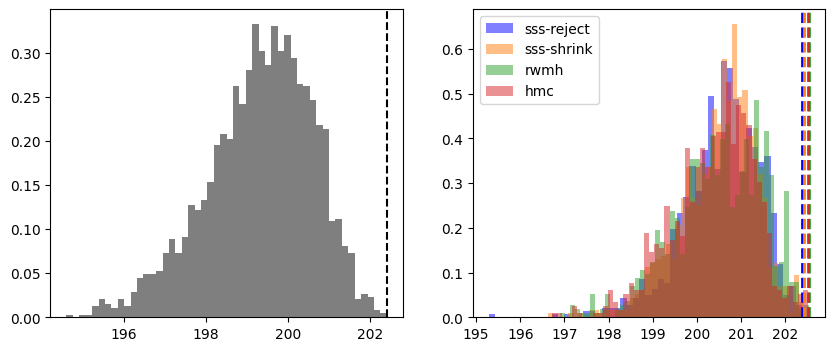

In [ ]:
# compare histogram of the log probs for all the methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
colors = ["blue", "tab:orange", "tab:green", "tab:red"]

ax1.hist(
    log_probs_tesselations,
    bins=50,
    alpha=0.5,
    label="tesselations",
    color="k",
    density=True,
)

logprob_best = np.max(log_probs_tesselations)
print(f"best systematic-search log prob: {logprob_best}")
ax1.axvline(logprob_best, color="k", ls="--", label="optimum")

for i, method in enumerate(methods):
    log_probs_method = log_probs[method]
    ax2.hist(
        log_probs_method,
        bins=50,
        alpha=0.5,
        label=method,
        color=colors[i],
        density=True,
    )
    kc_best_sampler = log_probs_method[np.argmax(log_probs_method)]
    print(f"best {method} log prob: {kc_best_sampler}")
    ax2.axvline(
        kc_best_sampler,
        lw=2,
        color=colors[i],
        ls="--",
    )
    ax2.legend(loc="upper left")

In [ ]:
if False:
    if scoring_metric == "MoG":
        # plotting the log mixture of spherical gaussian as histogram
        loadpath = "results/reg_3d2d_tesselation_testing_3/logprobs_3d2d_C600_MixtureSphericalGaussians_K20_projection_idx10.npz"
        logMoSG_truth = np.load(loadpath)
        plt.figure()
        plt.hist(
            logMoSG_truth["log_prob"],
            bins=50,
            alpha=0.5,
            label="log-MoSG",
            color="black",
        )
        plt.axvline(
            logMoSG_truth["log_prob"][np.argmax(logMoSG_truth["log_prob"])],
            lw=2,
            color="black",
            ls="--",
            label="argmax",
        )
        plt.legend()

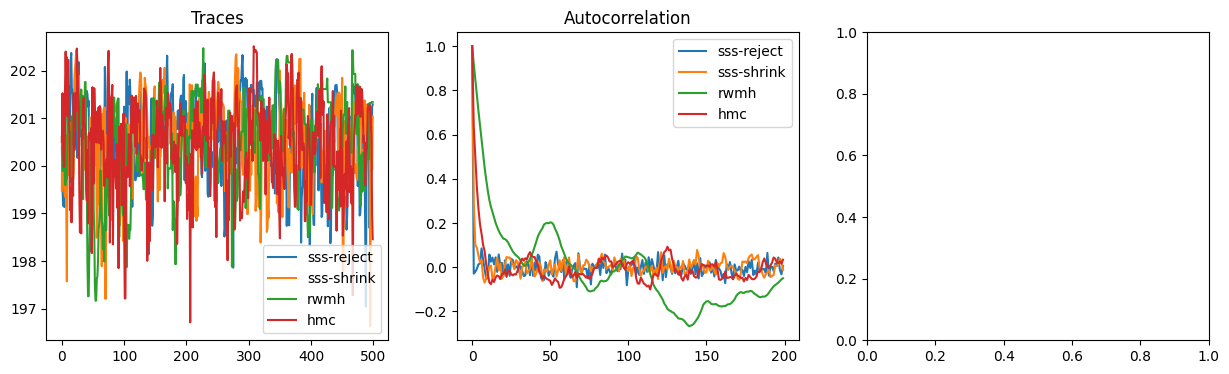

In [ ]:
import arviz as az

# Traces
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for method in methods:
    ax1.plot(log_probs[method][:500], label=method)
    ax1.legend()
    ax1.set_title("Traces")

# Autocorrelation
max_lag = 200
for method in methods:
    autocorrs = az.autocorr(samples[method][:, 0])
    ax2.plot(autocorrs[:max_lag], label=method)
    ax2.legend()
    ax2.set_title("Autocorrelation")

if is_multichained:
    # Effective sample size per dimension for all methods
    ess_vals = [
        az.ess(az.convert_to_dataset(samples_chains[method]), relative=True)
        .to_dataarray()
        .values[0]
        for method in methods
    ]

    # boxplot of ESS (over all dimensions) for every method
    bplot = ax3.boxplot(
        ess_vals,
        tick_labels=methods,
        patch_artist=True,
        medianprops={"color": "white", "linewidth": 0.5},
    )
    plt.xticks(rotation=30)
    ax3.grid(True, linestyle="--", alpha=0.7)
    ax3.set_ylabel("Effective sample size (ESS)")
    ax3.set_title("Effective sample size")

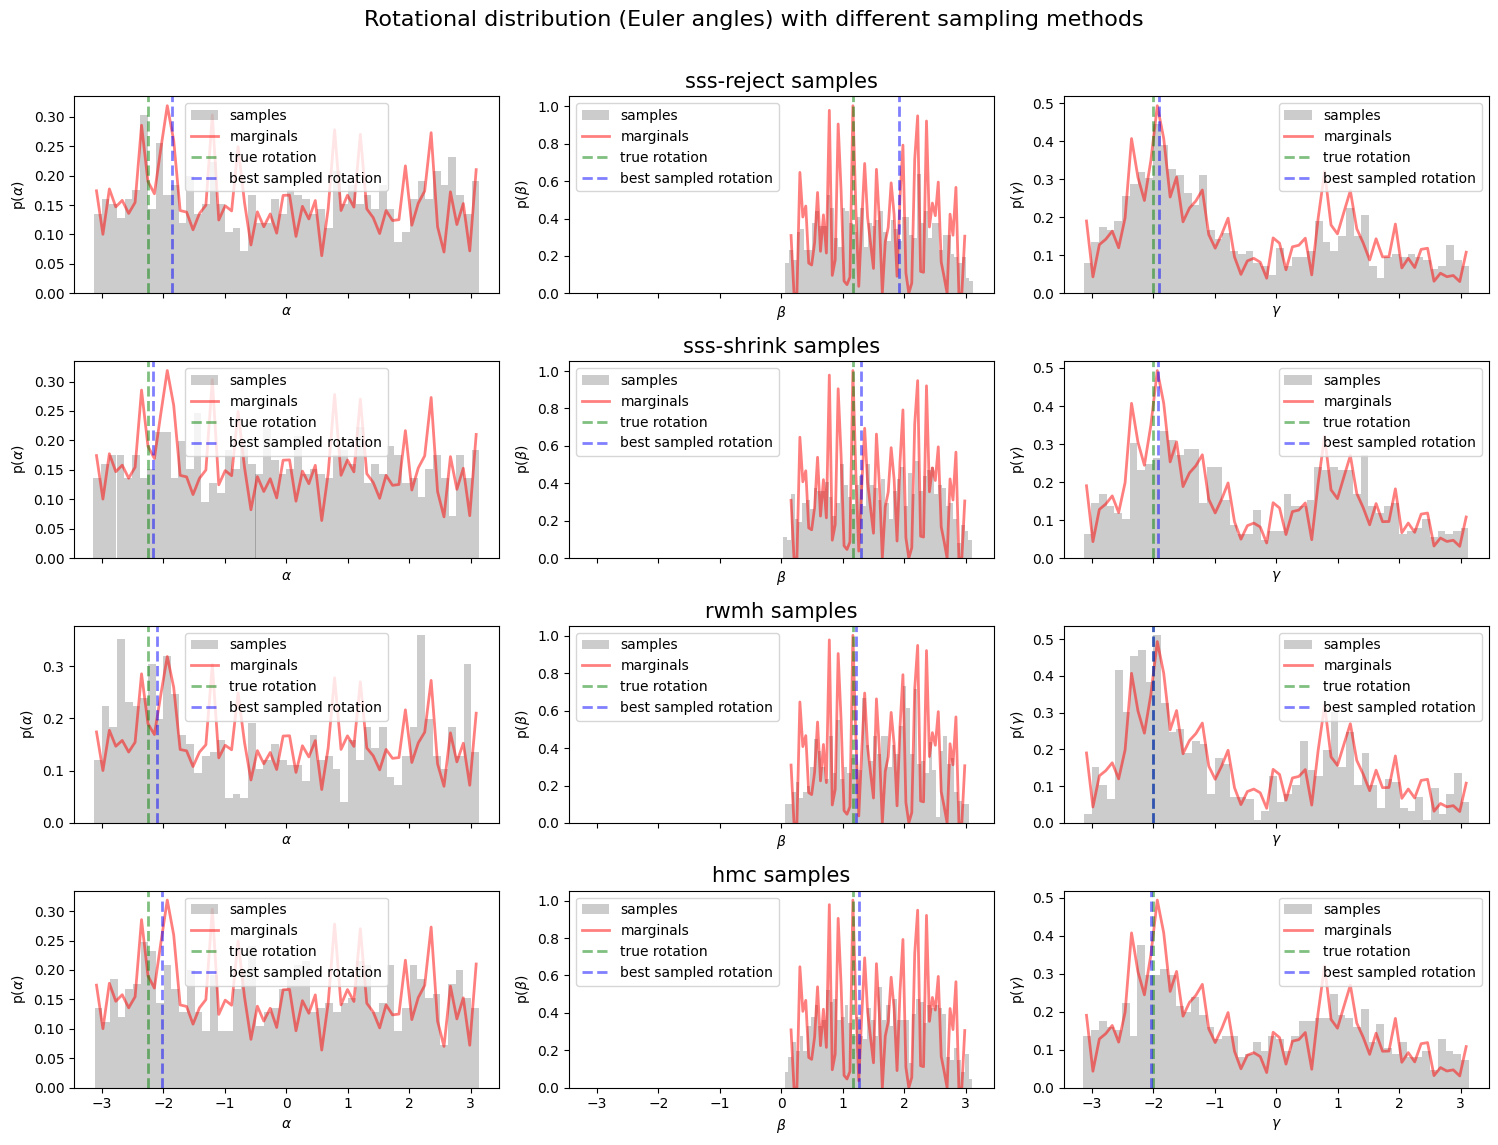

In [ ]:
from scipy.special import logsumexp

# normalize log probs
log_probs_tesselations -= logsumexp(log_probs_tesselations)
prob_tesselation = np.exp(log_probs_tesselations)

angles = Rotation.from_quat(quaternions).as_euler("zyz")
marginals_euler_tesselation = []
for x in angles.T:
    hist, bins = np.histogram(x, bins=60, weights=prob_tesselation, density=True)
    marginals_euler_tesselation.append((0.5 * (bins[:-1] + bins[1:]), hist))


# compare histograms in Euler angles with true marginals from systematic search
kw_hist = dict(bins=50, density=True, color="k", alpha=0.2)
x_labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

# Create a figure with 4 rows and 3 columns for the different load methods
fig, axes = plt.subplots(len(methods), 3, figsize=(15, 12), sharex="all")
fig.subplots_adjust(hspace=0.5)
axes = axes.reshape(len(methods), 3)

for row, load_method in enumerate(methods):
    samples_euler = Rotation.from_quat(samples[load_method]).as_euler("zyz")
    q_best_sampler = samples[load_method][np.argmax(log_probs[load_method])]
    q_best_sampler_euler = Rotation.from_quat(q_best_sampler).as_euler("zyz")

    for i in range(3):
        ax = axes[row, i]
        ax.hist(samples_euler[:, i], **kw_hist, label="samples")
        ax.plot(
            *marginals_euler_tesselation[i],
            color="r",
            label="marginals",
            alpha=0.5,
            lw=2,
        )
        ax.axvline(
            q_best_euler[i],
            color="g",
            ls="--",
            alpha=0.5,
            label="true rotation",
            lw=2,
        )
        ax.axvline(
            q_best_sampler_euler[i],
            color="b",
            ls="--",
            alpha=0.5,
            label="best sampled rotation",
            lw=2,
        )
        ax.set_xlabel(x_labels[i])
        ax.set_ylabel(f"p({x_labels[i]})")
        if i == 1:
            ax.set_title(f"{load_method} samples", fontsize=15)
        ax.legend()

# Add a super title for the entire figure
fig.suptitle(
    "Rotational distribution (Euler angles) with different sampling methods",
    fontsize=16,
)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

### Comparing scatter matrix in euler form.

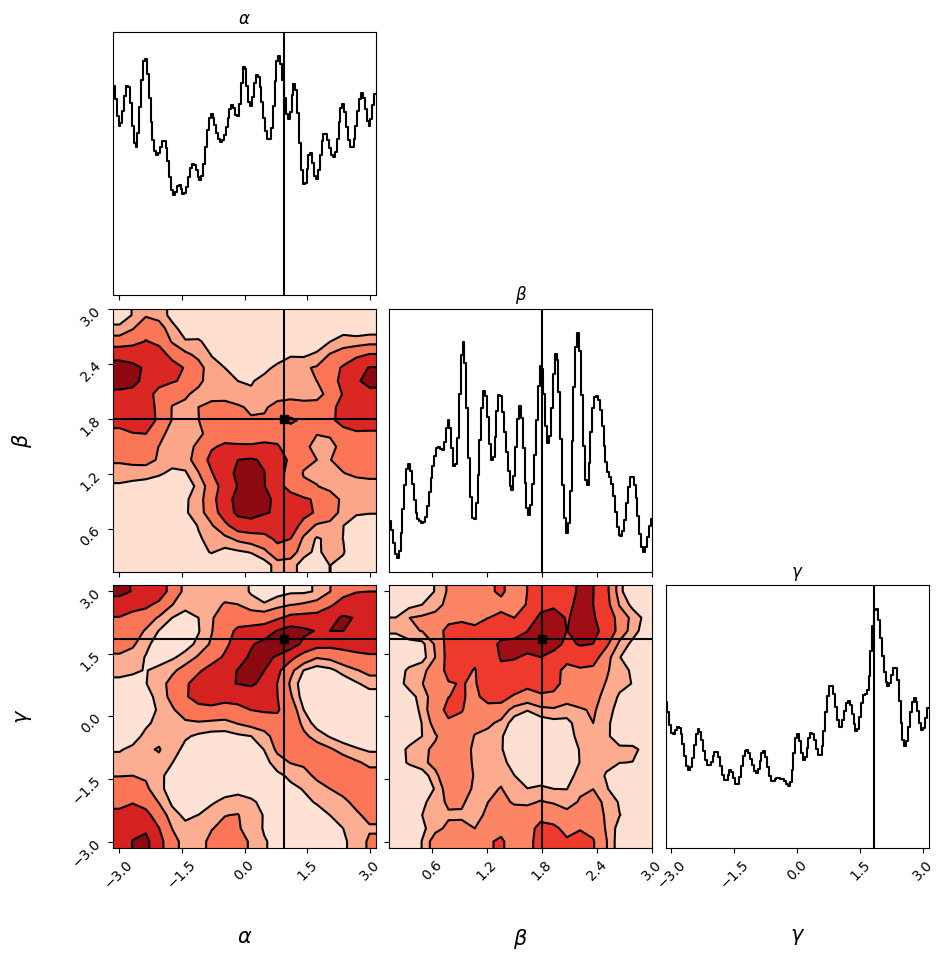

In [ ]:
import corner

figure = plt.figure(figsize=(10, 10))
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

# Generate the corner plot with weights and colormap
quat_tesselation_euler = Rotation.from_quat(quaternions).as_euler("zyz")
figure = corner.corner(
    quat_tesselation_euler,
    smooth=1.0,
    weights=prob_tesselation,
    fig=figure,
    hist_bin_factor=7,
    labels=labels,
    show_titles=True,
    title_fmt=None,
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    # levels=(0.11, 0.39, 0.67, 0.86),
    smooth1d=2,
    contourf_kwargs={"cmap": "Reds", "colors": None},  # Pass the colormap here
    labelsize=30,
    label_kwargs={"fontsize": 15, "labelpad": 0},
)

# Overplot the best quaternion
q_best_euler = quat_tesselation_euler[np.argmax(log_probs_tesselations)]
corner.overplot_lines(figure, q_best_euler, color="k", lw=1.5, label="true rotation")
corner.overplot_points(figure, q_best_euler[None], color="k", marker="s")

Optimal rotation via systematic search: [0.95067088 1.79939751 1.84042838]
Best sampled rotation for sss-reject: [1.19152103 1.89323358 1.86553679]
Best sampled rotation for sss-shrink: [1.19173842 1.91794187 1.94323878]
Best sampled rotation for rwmh: [-2.78758028  2.21439714  3.09573134]
Best sampled rotation for hmc: [1.19990291 1.72337823 1.90446063]


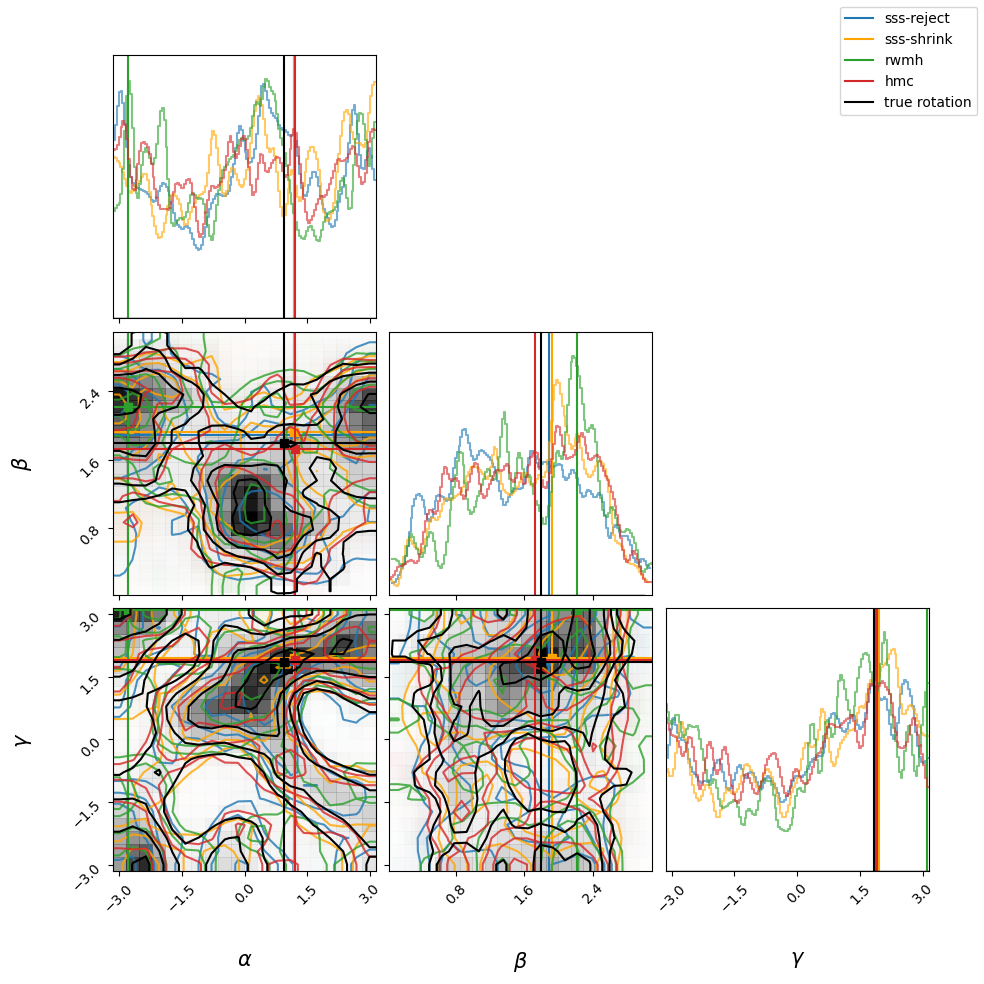

In [ ]:
# scatter matrices for all methods

# Initialize the figure
figure = plt.figure(figsize=(10, 10))
colors = ["tab:blue", "orange", "tab:green", "tab:red"]
print(f"Optimal rotation via systematic search: {q_best_euler}")

# Create labels for your quaternion components
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

q_best_sampled = {}
# Iterate over each method and plot
for i, method in enumerate(methods):
    # samples_per_method = samples[method]
    samples_per_method = Rotation.from_quat(samples[method]).as_euler("zyz")
    q_best_sampled[method] = samples[method][np.argmax(log_probs[method])]
    q_best_sampled_euler = Rotation.from_quat(q_best_sampled[method]).as_euler("zyz")
    print(f"Best sampled rotation for {method}: {q_best_sampled_euler}")

    # Plot the corner plot for the current method
    figure = corner.corner(
        samples_per_method,
        bins=20,
        smooth=1.0,
        labels=labels,
        fig=figure,  # Overlay on the existing figure
        color=colors[i],
        hist_bin_factor=7,
        contour_kwargs={"alpha": 0.8, "colors": [colors[i]]},
        hist_kwargs={"alpha": 0.6, "color": colors[i]},
        smooth1d=2,
        labelsize=30,
        label_kwargs={"fontsize": 15, "labelpad": 5},
        plot_datapoints=False,  # Avoid plotting individual points
        fill_contours=False,  # Avoid filling contours to distinguish overlaps
        weights=log_probs[method],
        plot_contours=True,
        plot_density=True,
    )

    # Overplot the best sampled rotation
    corner.overplot_lines(figure, q_best_sampled_euler, color=colors[i], lw=1.5)
    corner.overplot_points(
        figure, q_best_sampled_euler[None], color=colors[i], marker="s"
    )

corner.corner(
    quat_tesselation_euler,
    weights=prob_tesselation,
    fig=figure,
    bins=20,
    smooth=1.0,
    color="k",
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    hist_bin_factor=7,
    alpha=0.6,
)

# Overplot the true rotation
corner.overplot_lines(figure, q_best_euler, color="black", lw=1.5)
corner.overplot_points(figure, q_best_euler[None], color="black", marker="s")

# Manually create legend entries
legend_elements = [
    plt.Line2D([0], [0], color=color, lw=1.5, label=f"{method}")
    for method, color in zip(methods, colors)
]
legend_elements.append(
    plt.Line2D([0], [0], color="black", lw=1.5, label="true rotation")
)

# Add the legend to the figure
figure.legend(handles=legend_elements, loc="upper right")

Best sampled rotation for sss-reject: [ 0.26831558 -0.76579785 -0.58390975 -0.02469506]
Best sampled rotation for sss-shrink: [-0.30040237  0.7614893   0.57435954  0.00189983]
Best sampled rotation for rwmh: [-0.17764433 -0.8766313   0.06862553  0.4418718 ]
Best sampled rotation for hmc: [-0.26186407  0.71233594  0.65104365  0.01212029]


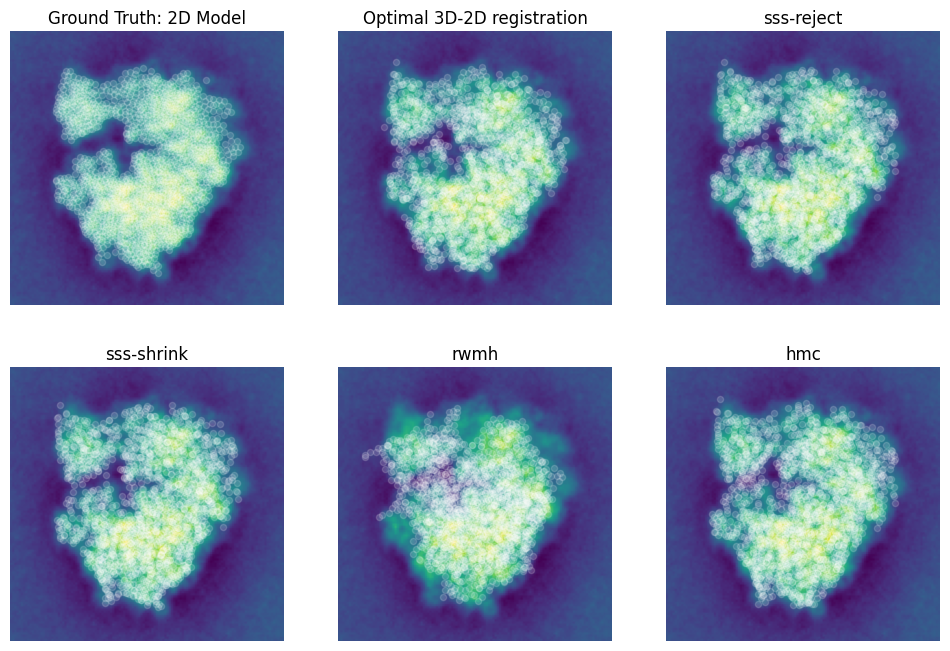

In [ ]:
# compare the best transfored source (after rotation and projection) with ground truth for all methods

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex="all", sharey="all")
axes = list(axes.flat)
for ax in axes:
    ax.set_xlim(-0.7 * limit, 0.7 * limit)
    ax.set_ylim(-0.7 * limit, 0.7 * limit)
    ax.set_axis_off()
    ax.imshow(image.T, extent=(-limit, limit, -limit, limit), origin="lower")

axes[0].set_title("Ground Truth: 2D Model")
axes[0].scatter(*target_fit2d.positions.T, color="w", alpha=0.15, s=20)

axes[1].set_title("Optimal 3D-2D registration")
axes[1].scatter(
    *source_cloud.transform_positions(q_best).T, color="w", alpha=0.15, s=20
)

for ax, method in zip(axes[2:], methods):
    print(f"Best sampled rotation for {method}: {q_best_sampled[method]}")

    ax.set_title(f"{method}")
    ax.scatter(
        *source_cloud.transform_positions(q_best_sampled[method]).T,
        color="w",
        alpha=0.15,
        s=20,
    )